# Turning COCO format into TFRecord

In [ ]:
import os
import zipfile

local_zip = "label_studio_coco_2.zip"

zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("label_studio_coco_2")
zip_ref.close()

In [ ]:
import tensorflow as tf
import json
import numpy as np


In [ ]:

json_path = 'label_studio_coco_2/result.json'
data_file = open(json_path)
data = json.load(data_file)

In [ ]:
data

In [ ]:
!pip install wandb matplotlib numpy pycocotools scikit-image imageio pandas

In [ ]:
! git clone https://github.com/Visual-Behavior/detr-tensorflow

Cloning into 'detr-tensorflow'...
remote: Enumerating objects: 388, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 388 (delta 0), reused 1 (delta 0), pack-reused 387
Receiving objects: 100% (388/388), 3.61 MiB | 24.62 MiB/s, done.
Resolving deltas: 100% (224/224), done.


In [ ]:
! mv /content/detr-tensorflow/detr_tf /content/detr_tf

In [ ]:
from detr_tf.data import load_coco_dataset
from detr_tf.training_config import TrainingConfig, DataConfig


In [ ]:
class MyConfig(TrainingConfig):
    def __init__(self):
        super().__init__()
        self.data_dir = "./label_studio_coco_2/"
        self.data = DataConfig(
            data_dir=self.data_dir,
            img_dir="",
            ann_file="result.json"
          )
        self.batch_size = 1

config = MyConfig()
iterator, class_names = load_coco_dataset(config, config.batch_size, augmentation=True)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
iterator

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(1, None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(1, None, 1), dtype=tf.int64, name=None))>

In [ ]:
class_names

['carros', 'motos', 'back']

In [ ]:
from detr_tf.inference import numpy_bbox_to_image
import matplotlib.pyplot as plt

In [ ]:
for images, target_bbox, target_class in iterator:
    print("images.shape", images.shape)
    print("target_bbox.shape", target_bbox.shape)
    print("target_class.shape", target_class.shape)
    first_value = (images, target_bbox, target_class)
    # Plot image
    # image = numpy_bbox_to_image(
    #     np.array(images[0]),
    #     np.array(target_bbox[0]),
    #     labels=np.array(target_class[0]),
    #     scores=None,
    #     class_name=class_names,
    #     config=config
    # )
    # plt.imshow(image)
    break

images.shape (1, 376, 672, 3)
target_bbox.shape (1, 100, 4)
target_class.shape (1, 100, 1)


/usr/local/lib/python3.10/dist-packages/imgaug/augmenters/meta.py:3368: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  augmenter_active = np.zeros((nb_rows, len(self)), dtype=np.bool)


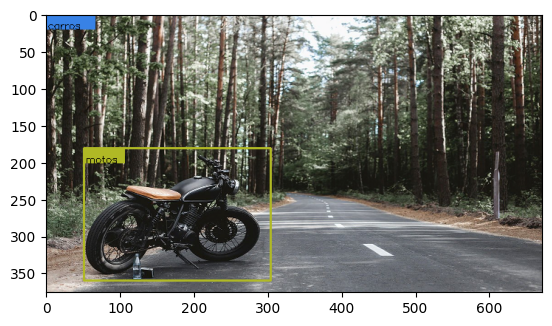

In [ ]:
image = numpy_bbox_to_image(
        np.array(first_value[0][0]),
        np.array(first_value[1][0]),
        labels=np.array(first_value[2][0]),
        scores=None,
        class_name=class_names,
        config=config
    )
plt.imshow(image)

# Leyendo de Pascal Voc para construir el CSV para volverlo TFRecord

In [ ]:
import os
import zipfile

local_zip = "label_studio_pascal_voc.zip"

zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("label_studio_pascal_voc")
zip_ref.close()

In [ ]:
import os
from xml.etree import ElementTree as ET

In [ ]:
folder_path = './label_studio_pascal_voc/Annotations'

In [ ]:
files = os.listdir(folder_path)
files

In [ ]:
for file in files:
    if file.endswith('.xml'):
        file_path = os.path.join(folder_path, file)
        tree = ET.parse(file_path)
        root = tree.getroot()
        print(root)

        break

<Element 'annotation' at 0x7e9344bf62a0>


In [ ]:
xml_file = files[1]
file_path = os.path.join(folder_path, xml_file)
tree = ET.parse(file_path)
root = tree.getroot()
for child in root:
    # Get the key and value attribute
    # object_at = child.attrib['object']
    # Print the key and value
    print(child)

<Element 'folder' at 0x7e937ccded40>
<Element 'filename' at 0x7e937ccde2a0>
<Element 'source' at 0x7e937ccde750>
<Element 'owner' at 0x7e937ccdeed0>
<Element 'size' at 0x7e937ccde250>
<Element 'segmented' at 0x7e937ccdf9c0>
<Element 'object' at 0x7e937ccdfb00>


# Colab AI suggestion

In [ ]:
import tensorflow as tf
import json

def convert_coco_to_tfrecord(input_file, output_file):
  """Converts a COCO dataset in JSON format to TFRecord format.

  Args:
    input_file: The path to the COCO JSON file.
    output_file: The path to the output TFRecord file.
  """

  with tf.io.gfile.GFile(input_file, 'r') as fid:
    data = json.load(fid)

  with tf.io.gfile.GFile(output_file, 'wb') as fid:
    for image in data['images']:
      with tf.io.gfile.GFile(image['coco_url'], 'rb') as image_fid:
        encoded_image = image_fid.read()

      image_format = image['file_name'].split('.')[-1]

      xmins = []
      xmaxs = []
      ymins = []
      ymaxs = []
      classes = []
      classes_text = []

      for annotation in data['annotations']:
        if annotation['image_id'] == image['id']:
          bbox = annotation['bbox']
          xmins.append(float(bbox[0]) / image['width'])
          xmaxs.append(float(bbox[0] + bbox[2]) / image['width'])
          ymins.append(float(bbox[1]) / image['height'])
          ymaxs.append(float(bbox[1] + bbox[3]) / image['height'])
          classes.append(annotation['category_id'])
          classes_text.append(annotation['category_id'].encode('utf8'))

      example = tf.train.Example(features=tf.train.Features(feature={
          'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[image['height']])),
          'image/width': tf.train.Feature(int64_list=tf.train.Int64List

# Transformar CSV a TFRecord

https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/tensorflow-1.14/training.html#converting-from-csv-to-record